<h1 style="text-align:center;"><b>Laboratorio 4</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

# Librerías

In [1]:
#import sys
#!{sys.executable} -m pip install --user "folium"

In [18]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

# Conexión

In [4]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


# Extracción de datos

## Coordenadas

In [5]:
#Areas de interes
lago_atitlan = {
    "west": -91.349,
    "east": -91.0702,
    "south": 14.5971,
    "north": 14.7648
}
lago_amatitlan = {
    "west": -90.66,
    "east": -90.58,
    "south": 14.43,
    "north": 14.51
}

## Conexión

In [8]:
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Descarga de imágenes

In [12]:
# Fechas sin nubosidad
fechas = ["2025-02-07", "2025-02-10", "2025-02-25", "2025-02-27", "2025-03-02", "2025-03-04", "2025-03-07", "2025-03-09", "2025-03-12", "2025-03-14", "2025-03-19", "2025-03-22", "2025-03-24", "2025-03-26", "2025-04-03", "2025-04-11", "2025-04-13", "2025-04-15", "2025-04-16", "2025-04-18", "2025-04-28", "2025-05-03", "2025-05-13", "2025-05-28", "2025-07-10", "2025-07-17", "2025-07-20", "2025-07-24", "2025-08-01"]

In [16]:
for fecha in fechas:
    try:
        # Lago Atitlán
        atitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_atitlan,
            temporal_extent=[fecha, fecha],  # o un rango más amplio
            bands=["B02","B03","B04", "B08"]
        )

        result_graph = atitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result_graph)
        job.start_and_wait()
        job.download_results(f"imgs1/{fecha}.tiff")

        # Lago Amatitlán
        amatitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_amatitlan,
            temporal_extent=[fecha, fecha],
            bands=["B02","B03","B04", "B08"]
        )

        result_graph = amatitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result_graph)
        job.start_and_wait()
        job.download_results(f"imgs2/{fecha}.tiff")

    except Exception as e:
        print(f"No se pudo procesar la fecha {fecha}: {e}")
        continue

0:00:00 Job 'j-2508120247354401bea0e97a70e68ef5': send 'start'
0:00:13 Job 'j-2508120247354401bea0e97a70e68ef5': created (progress 0%)
0:00:19 Job 'j-2508120247354401bea0e97a70e68ef5': created (progress 0%)
0:00:26 Job 'j-2508120247354401bea0e97a70e68ef5': created (progress 0%)
0:00:36 Job 'j-2508120247354401bea0e97a70e68ef5': running (progress N/A)
0:00:47 Job 'j-2508120247354401bea0e97a70e68ef5': running (progress N/A)
0:00:59 Job 'j-2508120247354401bea0e97a70e68ef5': running (progress N/A)
0:01:15 Job 'j-2508120247354401bea0e97a70e68ef5': running (progress N/A)
0:01:34 Job 'j-2508120247354401bea0e97a70e68ef5': finished (progress 100%)


/var/folders/p9/c7lshh9n1j55x6_b26v_sx1h0000gn/T/ipykernel_29112/1297175600.py:14: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(f"imgs1/{fecha}.tiff")


0:00:00 Job 'j-2508120251564983883d7fa7caf0aad2': send 'start'
0:00:13 Job 'j-2508120251564983883d7fa7caf0aad2': queued (progress 0%)
0:00:18 Job 'j-2508120251564983883d7fa7caf0aad2': queued (progress 0%)
0:00:25 Job 'j-2508120251564983883d7fa7caf0aad2': queued (progress 0%)
0:00:33 Job 'j-2508120251564983883d7fa7caf0aad2': queued (progress 0%)
0:00:43 Job 'j-2508120251564983883d7fa7caf0aad2': queued (progress 0%)
0:00:56 Job 'j-2508120251564983883d7fa7caf0aad2': queued (progress 0%)
0:01:12 Job 'j-2508120251564983883d7fa7caf0aad2': finished (progress 100%)


/var/folders/p9/c7lshh9n1j55x6_b26v_sx1h0000gn/T/ipykernel_29112/1297175600.py:27: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(f"imgs2/{fecha}.tiff")


0:00:00 Job 'j-2508120253394f31b72f4f94aa8ba432': send 'start'
0:00:13 Job 'j-2508120253394f31b72f4f94aa8ba432': created (progress 0%)
0:00:18 Job 'j-2508120253394f31b72f4f94aa8ba432': created (progress 0%)
0:00:25 Job 'j-2508120253394f31b72f4f94aa8ba432': created (progress 0%)
0:00:33 Job 'j-2508120253394f31b72f4f94aa8ba432': running (progress N/A)
0:00:43 Job 'j-2508120253394f31b72f4f94aa8ba432': running (progress N/A)
0:00:56 Job 'j-2508120253394f31b72f4f94aa8ba432': running (progress N/A)
0:01:12 Job 'j-2508120253394f31b72f4f94aa8ba432': running (progress N/A)
0:01:31 Job 'j-2508120253394f31b72f4f94aa8ba432': finished (progress 100%)
0:00:00 Job 'j-250812025601436ebf05f3d93d88d0a3': send 'start'
0:00:13 Job 'j-250812025601436ebf05f3d93d88d0a3': queued (progress 0%)
0:00:18 Job 'j-250812025601436ebf05f3d93d88d0a3': queued (progress 0%)
0:00:25 Job 'j-250812025601436ebf05f3d93d88d0a3': queued (progress 0%)
0:00:33 Job 'j-250812025601436ebf05f3d93d88d0a3': queued (progress 0%)
0:00:43

Failed to parse API error response: [503] 'no available server\n' (headers: {'Content-Type': 'text/plain; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Date': 'Tue, 12 Aug 2025 03:46:37 GMT', 'Content-Length': '20'})
Preflight process graph validation failed: [503] no available server

Failed to parse API error response: [503] 'no available server\n' (headers: {'Content-Type': 'text/plain; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Date': 'Tue, 12 Aug 2025 03:46:37 GMT', 'Content-Length': '20'})


No se pudo procesar la fecha 2025-03-19: [503] no available server



Failed to parse API error response: [503] 'no available server\n' (headers: {'Content-Type': 'text/plain; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Date': 'Tue, 12 Aug 2025 03:46:38 GMT', 'Content-Length': '20'})
Preflight process graph validation failed: [503] no available server

Failed to parse API error response: [503] 'no available server\n' (headers: {'Content-Type': 'text/plain; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Date': 'Tue, 12 Aug 2025 03:46:38 GMT', 'Content-Length': '20'})


No se pudo procesar la fecha 2025-03-22: [503] no available server



Failed to parse API error response: [503] 'no available server\n' (headers: {'Content-Type': 'text/plain; charset=utf-8', 'X-Content-Type-Options': 'nosniff', 'Date': 'Tue, 12 Aug 2025 03:46:38 GMT', 'Content-Length': '20'})
Preflight process graph validation failed: [503] no available server



0:00:00 Job 'j-2508120346394b80855377573011aa2d': send 'start'
0:00:13 Job 'j-2508120346394b80855377573011aa2d': created (progress 0%)
0:00:18 Job 'j-2508120346394b80855377573011aa2d': created (progress 0%)
0:00:25 Job 'j-2508120346394b80855377573011aa2d': created (progress 0%)
0:00:34 Job 'j-2508120346394b80855377573011aa2d': running (progress N/A)
0:00:44 Job 'j-2508120346394b80855377573011aa2d': running (progress N/A)
0:00:56 Job 'j-2508120346394b80855377573011aa2d': running (progress N/A)
0:01:13 Job 'j-2508120346394b80855377573011aa2d': running (progress N/A)
0:01:33 Job 'j-2508120346394b80855377573011aa2d': finished (progress 100%)
No se pudo procesar la fecha 2025-03-24: HTTPSConnectionPool(host='openeo.dataspace.copernicus.eu', port=443): Read timed out.
No se pudo procesar la fecha 2025-03-26: HTTPSConnectionPool(host='openeo.dataspace.copernicus.eu', port=443): Max retries exceeded with url: /openeo/1.2/collections/SENTINEL2_L2A (Caused by NameResolutionError("<urllib3.connec

# Preparación de datos

## Visualización de un ejemplo

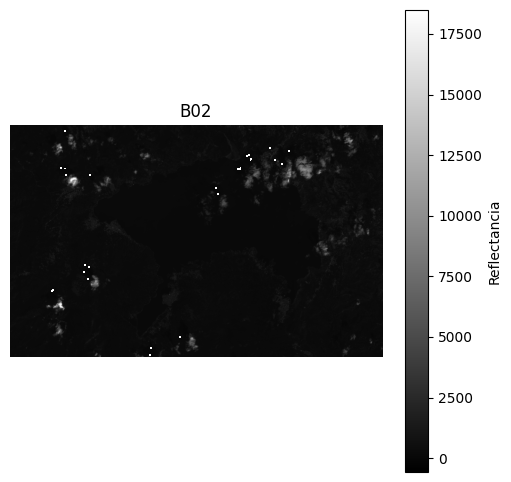

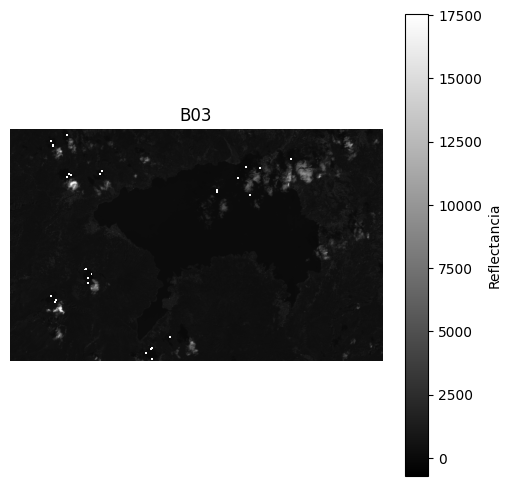

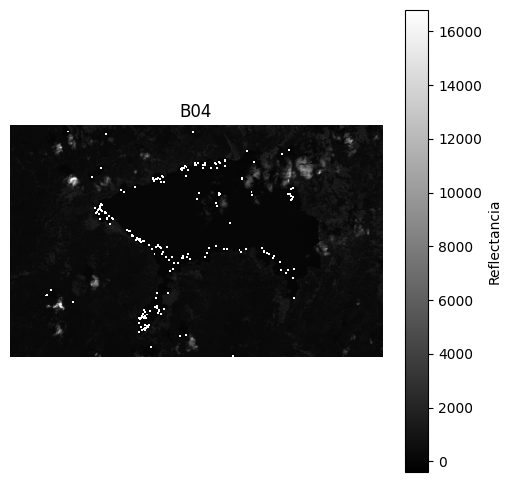

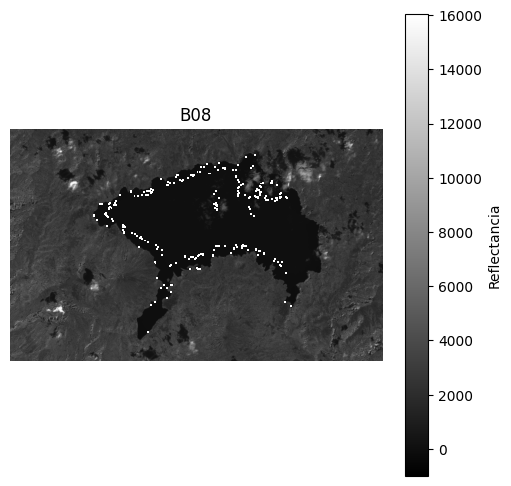

In [21]:
ruta_tif = "imgs1/2025-02-07.tiff"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

## Identificación de cianobacterias

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/ 